In [1]:
import warnings 
warnings.filterwarnings("ignore")

from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LabelFilterd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import numpy as np

import itk

import sys

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
if False: #len(sys.argv) == 3:
    device_num = int(sys.argv[1])
    num_devices = int(sys.argv[2])
    print("Using device", str(device_num),"of", str(num_devices))
else:
    print("Device number assumed to be 1")
    device_num = 3
    num_devices = 1


img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.interpolated-overlay.nii.gz')))

num_folds = 15

num_classes = 3

max_epochs = 1000

net_dims = 3
net_in_channels = 1
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)

num_workers_tr = 4
batch_size_tr = 8
num_workers_vl = 2
batch_size_vl = 2

num_slices = 48
size_x = 320
size_y = 320


model_filename_base = "./results/BAMC_PTX_ARUNet-3D-PR"

num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','215ns','218ns','219ns','221ns','247ns']
s_prefix = ['004s','019s','030s','034s','037s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    if i%2 == 0:
        num_ns = 1
        num_s = 1
        if i > num_folds-3:
            num_s = 2
    else:
        num_ns = 1
        num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)

Device number assumed to be 1
Num images / labels = 62 62


In [3]:
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

53 4 5
53 5 4
54 4 4
54 4 4
54 4 4
55 4 3
55 3 4
54 4 4
54 4 4
54 4 4
53 4 5
53 5 4
53 4 5
53 5 4
54 4 4


../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.nii.gz
../../Data/VFoldData/BAMC-PTXSliding-Annotations-Linear/081s_iimage_3320344386805_clean.interpolated-overlay.nii.gz


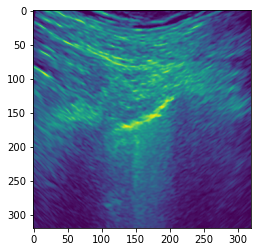

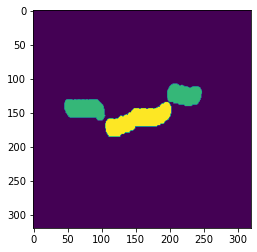

In [4]:
imgnum = 40 #10 for ns, 0 for s

print(train_files[0][imgnum]["image"])
print(train_files[0][imgnum]["label"])

img = itk.imread(train_files[0][imgnum]["image"])
arrimg = itk.GetArrayFromImage(img)
img = itk.imread(train_files[0][imgnum]["label"])
arrlbl = itk.GetArrayFromImage(img)

plt.subplots()
plt.imshow(arrimg[0,:,:])
plt.subplots()
plt.imshow(arrlbl[0,:,:])

In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image','label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            axis=3,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=0,
            keys=['image', 'label']),
        RandFlipd(prob=0.5, 
            spatial_axis=2,
            keys=['image', 'label']),
        RandZoomd(prob=0.5, 
            min_zoom=1.0,
            max_zoom=1.2,
            keep_size=True,
            mode=['trilinear', 'nearest'],
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AddChanneld(keys=['image', 'label']),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        Lambdad(
            func=lambda x: np.where(x==3,1,x),
            keys=['label']),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=num_slices,
            center_slice=30,
            axis=3,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [6]:
train_ds = [CacheDataset(data=train_files[i], transform=train_transforms,cache_rate=1.0, num_workers=num_workers_tr)
            for i in range(num_folds)]
train_loader = [DataLoader(train_ds[i], batch_size=batch_size_tr, shuffle=True, num_workers=num_workers_tr) 
                for i in range(num_folds)]

val_ds = [CacheDataset(data=val_files[i], transform=val_transforms, cache_rate=1.0, num_workers=num_workers_vl)
          for i in range(num_folds)]
val_loader = [DataLoader(val_ds[i], batch_size=batch_size_vl, num_workers=num_workers_vl)
              for i in range(num_folds)]

Loading dataset: 100%|████████████████████████████| 4/4 [00:00<00:00, 11.03it/s]


torch.Size([2, 1, 320, 320, 48])
torch.Size([1, 320, 320, 48])
image shape: torch.Size([1, 320, 320, 48]), label shape: torch.Size([1, 320, 320, 48])


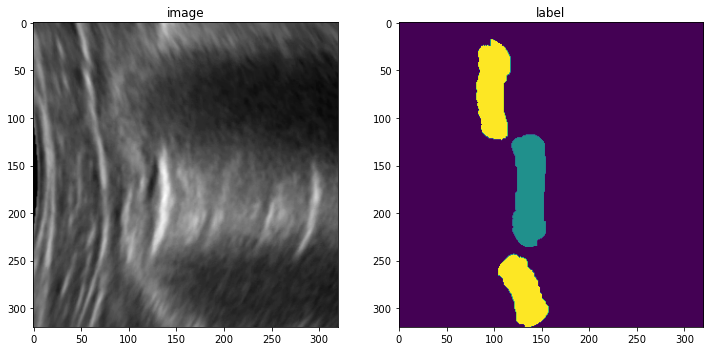

tensor(0.) tensor(2.)


In [7]:
imgnum = 0
check_data = first(val_loader[0])
image, label = (check_data["image"][imgnum], check_data["label"][imgnum])
print(check_data["image"].shape)
print(image.shape)
print(f"image shape: {image.shape}, label shape: {label.shape}")
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0, :, :, 24], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, 24])
plt.show()
print(label.min(), label.max())

In [8]:
device = torch.device("cuda:"+str(device_num))


In [9]:
def vfold_train(vfold_num, train_loader, val_loader):
    model = UNet(
        dimensions=net_dims,
        in_channels=net_in_channels,
        out_channels=num_classes,
        channels=net_channels,
        strides=net_strides,
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    loss_function = DiceLoss(to_onehot_y=True, softmax=True)
    optimizer = torch.optim.Adam(model.parameters(), 1e-4)
    dice_metric = DiceMetric(include_background=False, reduction="mean")

    val_interval = 2
    best_metric = -1
    best_metric_epoch = -1
    epoch_loss_values = []
    metric_values = []

    post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=True, num_classes=num_classes)])
    post_label = Compose([EnsureType(), AsDiscrete(to_onehot=True, num_classes=num_classes)])

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"{vfold_num}: epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["image"].to(device),
                batch_data["label"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, "
                  f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"{vfold_num} epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["image"].to(device),
                        val_data["label"].to(device),
                    )
                    roi_size = (size_x, size_y, num_slices)
                    sw_batch_size = batch_size_vl
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if epoch > 100:
                    metric = (metric_values[-1]+metric_values[-2])/2
                    if metric > best_metric:
                        best_metric = metric
                        best_metric_epoch = epoch + 1
                        torch.save(model.state_dict(), model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth')
                        print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )
                torch.save(model.state_dict(), model_filename_base+'.last_model.vfold_'+str(vfold_num)+'.pth')

    np.save(model_filename_base+"_loss_"+str(vfold_num)+".npy", epoch_loss_values)
    np.save(model_filename_base+"_val_dice_"+str(vfold_num)+".npy", metric_values)

    

In [ ]:
for i in range(11,num_folds,num_devices):
        vfold_train(i, train_loader[i], val_loader[i])

----------
11: epoch 1/1000
1/1, train_loss: 0.7979
2/1, train_loss: 0.7933
3/1, train_loss: 0.7996
4/1, train_loss: 0.7970
5/1, train_loss: 0.7905
6/1, train_loss: 0.7942
7/1, train_loss: 0.7946
11 epoch 1 average loss: 0.7953
----------
11: epoch 2/1000
1/1, train_loss: 0.7792
2/1, train_loss: 0.7868
3/1, train_loss: 0.7833
4/1, train_loss: 0.7821
5/1, train_loss: 0.7841
6/1, train_loss: 0.7725
7/1, train_loss: 0.7844
11 epoch 2 average loss: 0.7818
current epoch: 2 current mean dice: 0.0616
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 3/1000
1/1, train_loss: 0.7814
2/1, train_loss: 0.7724
3/1, train_loss: 0.7747
4/1, train_loss: 0.7652
5/1, train_loss: 0.7663
6/1, train_loss: 0.7692
7/1, train_loss: 0.7645
11 epoch 3 average loss: 0.7705
----------
11: epoch 4/1000
1/1, train_loss: 0.7567
2/1, train_loss: 0.7632
3/1, train_loss: 0.7624
4/1, train_loss: 0.7655
5/1, train_loss: 0.7548
6/1, train_loss: 0.7551
7/1, train_loss: 0.7638
11 epoch 4 average loss: 0.7602
current 

4/1, train_loss: 0.6311
5/1, train_loss: 0.6409
6/1, train_loss: 0.6226
7/1, train_loss: 0.6091
11 epoch 31 average loss: 0.6278
----------
11: epoch 32/1000
1/1, train_loss: 0.6248
2/1, train_loss: 0.6339
3/1, train_loss: 0.6270
4/1, train_loss: 0.6233
5/1, train_loss: 0.6192
6/1, train_loss: 0.6248
7/1, train_loss: 0.6283
11 epoch 32 average loss: 0.6259
current epoch: 32 current mean dice: 0.2319
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 33/1000
1/1, train_loss: 0.6136
2/1, train_loss: 0.6097
3/1, train_loss: 0.6296
4/1, train_loss: 0.6227
5/1, train_loss: 0.6286
6/1, train_loss: 0.6402
7/1, train_loss: 0.6146
11 epoch 33 average loss: 0.6227
----------
11: epoch 34/1000
1/1, train_loss: 0.6305
2/1, train_loss: 0.6069
3/1, train_loss: 0.6153
4/1, train_loss: 0.6081
5/1, train_loss: 0.6219
6/1, train_loss: 0.6294
7/1, train_loss: 0.6309
11 epoch 34 average loss: 0.6204
current epoch: 34 current mean dice: 0.3700
best mean dice: -1.0000 at epoch: -1
----------
11: epoc

11 epoch 61 average loss: 0.5048
----------
11: epoch 62/1000
1/1, train_loss: 0.5149
2/1, train_loss: 0.5220
3/1, train_loss: 0.4917
4/1, train_loss: 0.4897
5/1, train_loss: 0.5030
6/1, train_loss: 0.5031
7/1, train_loss: 0.5052
11 epoch 62 average loss: 0.5042
current epoch: 62 current mean dice: 0.4712
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 63/1000
1/1, train_loss: 0.4982
2/1, train_loss: 0.5001
3/1, train_loss: 0.4959
4/1, train_loss: 0.5068
5/1, train_loss: 0.5327
6/1, train_loss: 0.4735
7/1, train_loss: 0.4912
11 epoch 63 average loss: 0.4998
----------
11: epoch 64/1000
1/1, train_loss: 0.5023
2/1, train_loss: 0.5050
3/1, train_loss: 0.4788
4/1, train_loss: 0.4877
5/1, train_loss: 0.4858
6/1, train_loss: 0.5242
7/1, train_loss: 0.4733
11 epoch 64 average loss: 0.4939
current epoch: 64 current mean dice: 0.3681
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 65/1000
1/1, train_loss: 0.4988
2/1, train_loss: 0.4802
3/1, train_loss: 0.4881
4/1, train_los

2/1, train_loss: 0.3943
3/1, train_loss: 0.3993
4/1, train_loss: 0.4074
5/1, train_loss: 0.3776
6/1, train_loss: 0.4123
7/1, train_loss: 0.4318
11 epoch 92 average loss: 0.4042
current epoch: 92 current mean dice: 0.5028
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 93/1000
1/1, train_loss: 0.3977
2/1, train_loss: 0.4228
3/1, train_loss: 0.4100
4/1, train_loss: 0.3910
5/1, train_loss: 0.3802
6/1, train_loss: 0.3874
7/1, train_loss: 0.3942
11 epoch 93 average loss: 0.3976
----------
11: epoch 94/1000
1/1, train_loss: 0.4053
2/1, train_loss: 0.4067
3/1, train_loss: 0.3984
4/1, train_loss: 0.4085
5/1, train_loss: 0.3837
6/1, train_loss: 0.3787
7/1, train_loss: 0.4019
11 epoch 94 average loss: 0.3976
current epoch: 94 current mean dice: 0.5446
best mean dice: -1.0000 at epoch: -1
----------
11: epoch 95/1000
1/1, train_loss: 0.4107
2/1, train_loss: 0.4016
3/1, train_loss: 0.3974
4/1, train_loss: 0.3863
5/1, train_loss: 0.3990
6/1, train_loss: 0.3813
7/1, train_loss: 0.3737
11 e

1/1, train_loss: 0.2737
2/1, train_loss: 0.2844
3/1, train_loss: 0.2653
4/1, train_loss: 0.2671
5/1, train_loss: 0.2739
6/1, train_loss: 0.2601
7/1, train_loss: 0.2645
11 epoch 122 average loss: 0.2699
current epoch: 122 current mean dice: 0.6320
best mean dice: 0.6398 at epoch: 106
----------
11: epoch 123/1000
1/1, train_loss: 0.2543
2/1, train_loss: 0.2738
3/1, train_loss: 0.2632
4/1, train_loss: 0.2595
5/1, train_loss: 0.2612
6/1, train_loss: 0.2660
7/1, train_loss: 0.2911
11 epoch 123 average loss: 0.2670
----------
11: epoch 124/1000
1/1, train_loss: 0.2615
2/1, train_loss: 0.2674
3/1, train_loss: 0.2588
4/1, train_loss: 0.2635
5/1, train_loss: 0.2733
6/1, train_loss: 0.2456
7/1, train_loss: 0.2370
11 epoch 124 average loss: 0.2582
saved new best metric model
current epoch: 124 current mean dice: 0.6508
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 125/1000
1/1, train_loss: 0.2421
2/1, train_loss: 0.2734
3/1, train_loss: 0.2671
4/1, train_loss: 0.2481
5/1, train_loss:

1/1, train_loss: 0.1764
2/1, train_loss: 0.1884
3/1, train_loss: 0.1959
4/1, train_loss: 0.1738
5/1, train_loss: 0.1801
6/1, train_loss: 0.1842
7/1, train_loss: 0.1757
11 epoch 152 average loss: 0.1821
current epoch: 152 current mean dice: 0.6007
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 153/1000
1/1, train_loss: 0.1837
2/1, train_loss: 0.1814
3/1, train_loss: 0.1659
4/1, train_loss: 0.1866
5/1, train_loss: 0.1868
6/1, train_loss: 0.1578
7/1, train_loss: 0.1831
11 epoch 153 average loss: 0.1779
----------
11: epoch 154/1000
1/1, train_loss: 0.1777
2/1, train_loss: 0.1794
3/1, train_loss: 0.1685
4/1, train_loss: 0.1736
5/1, train_loss: 0.1879
6/1, train_loss: 0.2001
7/1, train_loss: 0.1747
11 epoch 154 average loss: 0.1803
current epoch: 154 current mean dice: 0.5832
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 155/1000
1/1, train_loss: 0.1775
2/1, train_loss: 0.1826
3/1, train_loss: 0.1753
4/1, train_loss: 0.1679
5/1, train_loss: 0.1884
6/1, train_loss: 0.1

2/1, train_loss: 0.1608
3/1, train_loss: 0.1390
4/1, train_loss: 0.1513
5/1, train_loss: 0.1506
6/1, train_loss: 0.1587
7/1, train_loss: 0.1477
11 epoch 182 average loss: 0.1512
current epoch: 182 current mean dice: 0.6157
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 183/1000
1/1, train_loss: 0.1543
2/1, train_loss: 0.1559
3/1, train_loss: 0.1535
4/1, train_loss: 0.1544
5/1, train_loss: 0.1424
6/1, train_loss: 0.1637
7/1, train_loss: 0.1582
11 epoch 183 average loss: 0.1546
----------
11: epoch 184/1000
1/1, train_loss: 0.1668
2/1, train_loss: 0.1514
3/1, train_loss: 0.1489
4/1, train_loss: 0.1507
5/1, train_loss: 0.1545
6/1, train_loss: 0.1589
7/1, train_loss: 0.1517
11 epoch 184 average loss: 0.1547
current epoch: 184 current mean dice: 0.6196
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 185/1000
1/1, train_loss: 0.1486
2/1, train_loss: 0.1527
3/1, train_loss: 0.1602
4/1, train_loss: 0.1517
5/1, train_loss: 0.1511
6/1, train_loss: 0.1488
7/1, train_loss: 0.1

3/1, train_loss: 0.1343
4/1, train_loss: 0.1375
5/1, train_loss: 0.1389
6/1, train_loss: 0.1345
7/1, train_loss: 0.1484
11 epoch 212 average loss: 0.1399
current epoch: 212 current mean dice: 0.6095
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 213/1000
1/1, train_loss: 0.1519
2/1, train_loss: 0.1426
3/1, train_loss: 0.1446
4/1, train_loss: 0.1346
5/1, train_loss: 0.1376
6/1, train_loss: 0.1416
7/1, train_loss: 0.1481
11 epoch 213 average loss: 0.1430
----------
11: epoch 214/1000
1/1, train_loss: 0.1333
2/1, train_loss: 0.1433
3/1, train_loss: 0.1469
4/1, train_loss: 0.1314
5/1, train_loss: 0.1332
6/1, train_loss: 0.1244
7/1, train_loss: 0.1350
11 epoch 214 average loss: 0.1353
current epoch: 214 current mean dice: 0.6171
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 215/1000
1/1, train_loss: 0.1345
2/1, train_loss: 0.1399
3/1, train_loss: 0.1603
4/1, train_loss: 0.1223
5/1, train_loss: 0.1427
6/1, train_loss: 0.1359
7/1, train_loss: 0.1566
11 epoch 215 average

4/1, train_loss: 0.1323
5/1, train_loss: 0.1249
6/1, train_loss: 0.1178
7/1, train_loss: 0.1387
11 epoch 242 average loss: 0.1324
current epoch: 242 current mean dice: 0.6087
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 243/1000
1/1, train_loss: 0.1317
2/1, train_loss: 0.1316
3/1, train_loss: 0.1206
4/1, train_loss: 0.1422
5/1, train_loss: 0.1246
6/1, train_loss: 0.1358
7/1, train_loss: 0.1292
11 epoch 243 average loss: 0.1308
----------
11: epoch 244/1000
1/1, train_loss: 0.1335
2/1, train_loss: 0.1283
3/1, train_loss: 0.1376
4/1, train_loss: 0.1437
5/1, train_loss: 0.1377
6/1, train_loss: 0.1225
7/1, train_loss: 0.1466
11 epoch 244 average loss: 0.1357
current epoch: 244 current mean dice: 0.5933
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 245/1000
1/1, train_loss: 0.1304
2/1, train_loss: 0.1235
3/1, train_loss: 0.1301
4/1, train_loss: 0.1311
5/1, train_loss: 0.1398
6/1, train_loss: 0.1227
7/1, train_loss: 0.1323
11 epoch 245 average loss: 0.1300
----------

5/1, train_loss: 0.1243
6/1, train_loss: 0.1324
7/1, train_loss: 0.1321
11 epoch 272 average loss: 0.1278
current epoch: 272 current mean dice: 0.5725
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 273/1000
1/1, train_loss: 0.1358
2/1, train_loss: 0.1194
3/1, train_loss: 0.1369
4/1, train_loss: 0.1336
5/1, train_loss: 0.1202
6/1, train_loss: 0.1278
7/1, train_loss: 0.1357
11 epoch 273 average loss: 0.1299
----------
11: epoch 274/1000
1/1, train_loss: 0.1278
2/1, train_loss: 0.1170
3/1, train_loss: 0.1219
4/1, train_loss: 0.1285
5/1, train_loss: 0.1294
6/1, train_loss: 0.1345
7/1, train_loss: 0.1137
11 epoch 274 average loss: 0.1247
current epoch: 274 current mean dice: 0.6096
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 275/1000
1/1, train_loss: 0.1311
2/1, train_loss: 0.1254
3/1, train_loss: 0.1211
4/1, train_loss: 0.1336
5/1, train_loss: 0.1265
6/1, train_loss: 0.1219
7/1, train_loss: 0.1188
11 epoch 275 average loss: 0.1255
----------
11: epoch 276/1000
1/1,

6/1, train_loss: 0.1193
7/1, train_loss: 0.1240
11 epoch 302 average loss: 0.1192
current epoch: 302 current mean dice: 0.5850
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 303/1000
1/1, train_loss: 0.1220
2/1, train_loss: 0.1405
3/1, train_loss: 0.1256
4/1, train_loss: 0.1204
5/1, train_loss: 0.1188
6/1, train_loss: 0.1127
7/1, train_loss: 0.1133
11 epoch 303 average loss: 0.1219
----------
11: epoch 304/1000
1/1, train_loss: 0.1272
2/1, train_loss: 0.1278
3/1, train_loss: 0.1090
4/1, train_loss: 0.1259
5/1, train_loss: 0.1191
6/1, train_loss: 0.1191
7/1, train_loss: 0.1201
11 epoch 304 average loss: 0.1212
current epoch: 304 current mean dice: 0.5706
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 305/1000
1/1, train_loss: 0.1264
2/1, train_loss: 0.1181
3/1, train_loss: 0.1207
4/1, train_loss: 0.1214
5/1, train_loss: 0.1211
6/1, train_loss: 0.1175
7/1, train_loss: 0.1271
11 epoch 305 average loss: 0.1217
----------
11: epoch 306/1000
1/1, train_loss: 0.1138
2/1,

7/1, train_loss: 0.1127
11 epoch 332 average loss: 0.1172
current epoch: 332 current mean dice: 0.5513
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 333/1000
1/1, train_loss: 0.1156
2/1, train_loss: 0.1076
3/1, train_loss: 0.1155
4/1, train_loss: 0.1161
5/1, train_loss: 0.1257
6/1, train_loss: 0.1202
7/1, train_loss: 0.1227
11 epoch 333 average loss: 0.1176
----------
11: epoch 334/1000
1/1, train_loss: 0.1147
2/1, train_loss: 0.1105
3/1, train_loss: 0.1269
4/1, train_loss: 0.1175
5/1, train_loss: 0.1287
6/1, train_loss: 0.1074
7/1, train_loss: 0.1155
11 epoch 334 average loss: 0.1173
current epoch: 334 current mean dice: 0.5561
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 335/1000
1/1, train_loss: 0.1135
2/1, train_loss: 0.1167
3/1, train_loss: 0.1132
4/1, train_loss: 0.1098
5/1, train_loss: 0.1134
6/1, train_loss: 0.1252
7/1, train_loss: 0.1315
11 epoch 335 average loss: 0.1176
----------
11: epoch 336/1000
1/1, train_loss: 0.1083
2/1, train_loss: 0.1222
3/1,

11 epoch 362 average loss: 0.1116
current epoch: 362 current mean dice: 0.5569
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 363/1000
1/1, train_loss: 0.1194
2/1, train_loss: 0.1101
3/1, train_loss: 0.1037
4/1, train_loss: 0.1164
5/1, train_loss: 0.1076
6/1, train_loss: 0.1238
7/1, train_loss: 0.1097
11 epoch 363 average loss: 0.1130
----------
11: epoch 364/1000
1/1, train_loss: 0.1115
2/1, train_loss: 0.1014
3/1, train_loss: 0.1156
4/1, train_loss: 0.1154
5/1, train_loss: 0.1244
6/1, train_loss: 0.1095
7/1, train_loss: 0.1152
11 epoch 364 average loss: 0.1133
current epoch: 364 current mean dice: 0.5649
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 365/1000
1/1, train_loss: 0.1177
2/1, train_loss: 0.1056
3/1, train_loss: 0.1227
4/1, train_loss: 0.1122
5/1, train_loss: 0.1128
6/1, train_loss: 0.1064
7/1, train_loss: 0.1176
11 epoch 365 average loss: 0.1136
----------
11: epoch 366/1000
1/1, train_loss: 0.1132
2/1, train_loss: 0.1349
3/1, train_loss: 0.1076
4/1,

current epoch: 392 current mean dice: 0.5761
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 393/1000
1/1, train_loss: 0.1081
2/1, train_loss: 0.1147
3/1, train_loss: 0.1141
4/1, train_loss: 0.0935
5/1, train_loss: 0.1086
6/1, train_loss: 0.1082
7/1, train_loss: 0.1200
11 epoch 393 average loss: 0.1096
----------
11: epoch 394/1000
1/1, train_loss: 0.1080
2/1, train_loss: 0.1004
3/1, train_loss: 0.0970
4/1, train_loss: 0.1136
5/1, train_loss: 0.1098
6/1, train_loss: 0.1148
7/1, train_loss: 0.1154
11 epoch 394 average loss: 0.1084
current epoch: 394 current mean dice: 0.5905
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 395/1000
1/1, train_loss: 0.1062
2/1, train_loss: 0.1043
3/1, train_loss: 0.1119
4/1, train_loss: 0.1171
5/1, train_loss: 0.1103
6/1, train_loss: 0.1112
7/1, train_loss: 0.1116
11 epoch 395 average loss: 0.1104
----------
11: epoch 396/1000
1/1, train_loss: 0.1069
2/1, train_loss: 0.1166
3/1, train_loss: 0.1013
4/1, train_loss: 0.1125
5/1, train_los

1/1, train_loss: 0.1168
2/1, train_loss: 0.1070
3/1, train_loss: 0.1004
4/1, train_loss: 0.1036
5/1, train_loss: 0.1066
6/1, train_loss: 0.0982
7/1, train_loss: 0.1087
11 epoch 423 average loss: 0.1059
----------
11: epoch 424/1000
1/1, train_loss: 0.1104
2/1, train_loss: 0.0976
3/1, train_loss: 0.1140
4/1, train_loss: 0.1020
5/1, train_loss: 0.1035
6/1, train_loss: 0.1160
7/1, train_loss: 0.1078
11 epoch 424 average loss: 0.1073
current epoch: 424 current mean dice: 0.5682
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 425/1000
1/1, train_loss: 0.1129
2/1, train_loss: 0.1211
3/1, train_loss: 0.1020
4/1, train_loss: 0.1127
5/1, train_loss: 0.0996
6/1, train_loss: 0.0961
7/1, train_loss: 0.0954
11 epoch 425 average loss: 0.1057
----------
11: epoch 426/1000
1/1, train_loss: 0.1029
2/1, train_loss: 0.1093
3/1, train_loss: 0.1096
4/1, train_loss: 0.1018
5/1, train_loss: 0.1110
6/1, train_loss: 0.1070
7/1, train_loss: 0.1163
11 epoch 426 average loss: 0.1083
current epoch: 426 c

2/1, train_loss: 0.1044
3/1, train_loss: 0.1084
4/1, train_loss: 0.0927
5/1, train_loss: 0.0947
6/1, train_loss: 0.1155
7/1, train_loss: 0.0984
11 epoch 453 average loss: 0.1015
----------
11: epoch 454/1000
1/1, train_loss: 0.0905
2/1, train_loss: 0.1027
3/1, train_loss: 0.0983
4/1, train_loss: 0.1025
5/1, train_loss: 0.1017
6/1, train_loss: 0.1060
7/1, train_loss: 0.1144
11 epoch 454 average loss: 0.1023
current epoch: 454 current mean dice: 0.5726
best mean dice: 0.6508 at epoch: 124
----------
11: epoch 455/1000
1/1, train_loss: 0.1003
2/1, train_loss: 0.1122
3/1, train_loss: 0.0960
4/1, train_loss: 0.1048
5/1, train_loss: 0.1024
6/1, train_loss: 0.1007
7/1, train_loss: 0.1147
11 epoch 455 average loss: 0.1044
----------
11: epoch 456/1000
1/1, train_loss: 0.1091
2/1, train_loss: 0.0975
3/1, train_loss: 0.1034
4/1, train_loss: 0.1172
5/1, train_loss: 0.1015
6/1, train_loss: 0.1011
7/1, train_loss: 0.1162
11 epoch 456 average loss: 0.1066
current epoch: 456 current mean dice: 0.5403